In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [68]:
np.random.seed(42)

# Генерация временных данных
dates = pd.date_range(start="2024-01-01", end="2024-03-31 23:00:00", freq='H')
df = pd.DataFrame({'datetime': dates})

# Временные признаки
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df['is_peak_hour'] = df['hour'].apply(lambda h: 1 if 18 <= h <= 22 else 0)

# Праздники / ивенты
event_days = set(np.random.choice(df['datetime'].dt.date.unique(), size=15, replace=False))
df['is_event_day'] = df['datetime'].dt.date.apply(lambda d: 1 if d in event_days else 0)
df

<ipython-input-68-42da0c10a5ad>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2024-01-01", end="2024-03-31 23:00:00", freq='H')


,datetime,hour,dayofweek,day,month,is_weekend,is_peak_hour,is_event_day
0,2024-01-01 00:00:00,0,0,1,1,0,0,1
1,2024-01-01 01:00:00,1,0,1,1,0,0,1
2,2024-01-01 02:00:00,2,0,1,1,0,0,1
3,2024-01-01 03:00:00,3,0,1,1,0,0,1
4,2024-01-01 04:00:00,4,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...
2179,2024-03-31 19:00:00,19,6,31,3,1,1,0
2180,2024-03-31 20:00:00,20,6,31,3,1,1,0
2181,2024-03-31 21:00:00,21,6,31,3,1,1,0
2182,2024-03-31 22:00:00,22,6,31,3,1,1,0


In [69]:
# Генерация пользователей
def simulate_users(row):
    base = 10
    if row['is_weekend']:
        base += 10
    if row['is_peak_hour']:
        base += 20
    if row['is_event_day']:
        base += 30
    noise = np.random.normal(0, 5)
    lam = max(0, base + noise)
    return int(np.random.poisson(lam))

In [70]:
df['users_online'] = df.apply(simulate_users, axis=1)

# Исторические признаки
df['prev_hour_users'] = df['users_online'].shift(1)
df['prev_2_hour_users'] = df['users_online'].shift(2)
df['prev_3_hour_users'] = df['users_online'].shift(3)
df['rolling_mean_3h'] = df['users_online'].rolling(3).mean()
df['rolling_std_3h'] = df['users_online'].rolling(3).std()

# Обработка пропусков
for col in ['prev_hour_users', 'prev_2_hour_users', 'prev_3_hour_users', 'rolling_mean_3h', 'rolling_std_3h']:
    df[col].fillna(df['users_online'].mean(), inplace=True)
df

<ipython-input-70-67be5d408b00>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df['users_online'].mean(), inplace=True)


,datetime,hour,dayofweek,day,month,is_weekend,is_peak_hour,is_event_day,users_online,prev_hour_users,prev_2_hour_users,prev_3_hour_users,rolling_mean_3h,rolling_std_3h
0,2024-01-01 00:00:00,0,0,1,1,0,0,1,40,21.75,21.75,21.75,21.750000,21.750000
1,2024-01-01 01:00:00,1,0,1,1,0,0,1,49,40.00,21.75,21.75,21.750000,21.750000
2,2024-01-01 02:00:00,2,0,1,1,0,0,1,43,49.00,40.00,21.75,44.000000,4.582576
3,2024-01-01 03:00:00,3,0,1,1,0,0,1,35,43.00,49.00,40.00,42.333333,7.023769
4,2024-01-01 04:00:00,4,0,1,1,0,0,1,39,35.00,43.00,49.00,39.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2024-03-31 19:00:00,19,6,31,3,1,1,0,37,46.00,26.00,30.00,36.333333,10.016653
2180,2024-03-31 20:00:00,20,6,31,3,1,1,0,41,37.00,46.00,26.00,41.333333,4.509250
2181,2024-03-31 21:00:00,21,6,31,3,1,1,0,54,41.00,37.00,46.00,44.000000,8.888194
2182,2024-03-31 22:00:00,22,6,31,3,1,1,0,36,54.00,41.00,37.00,43.666667,9.291573


<ipython-input-71-cf2e11b315d7>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="hour", y="users_online", ci=None)


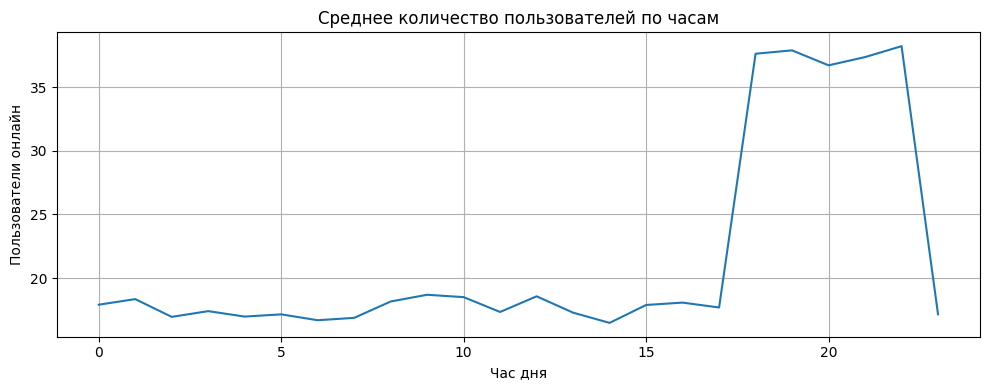

In [71]:
# Визуализация по часам
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="hour", y="users_online", ci=None)
plt.title("Среднее количество пользователей по часам")
plt.xlabel("Час дня")
plt.ylabel("Пользователи онлайн")
plt.grid(True)
plt.tight_layout()
plt.show()

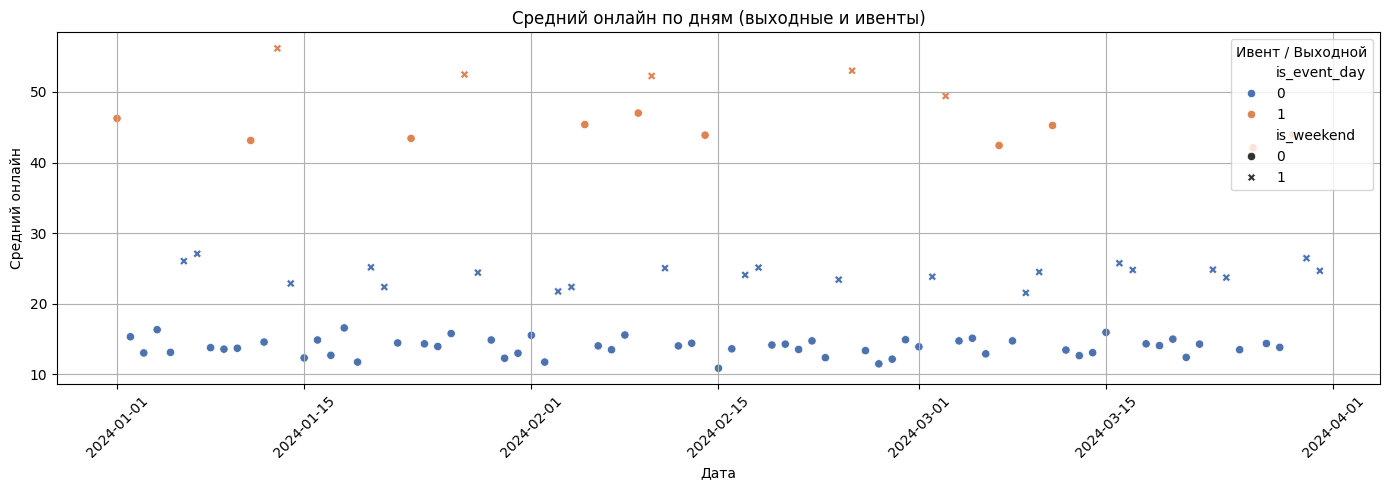

In [72]:
# Визуализация по дням
df['date'] = df['datetime'].dt.date
daily_avg = df.groupby('date').agg({
    'users_online': 'mean',
    'is_weekend': 'max',
    'is_event_day': 'max'
}).reset_index()

plt.figure(figsize=(14, 5))
sns.scatterplot(
    data=daily_avg,
    x='date',
    y='users_online',
    hue='is_event_day',
    style='is_weekend',
    palette='deep'
)
plt.title("Средний онлайн по дням (выходные и ивенты)")
plt.xlabel("Дата")
plt.ylabel("Средний онлайн")
plt.legend(title='Ивент / Выходной', loc='upper right')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# ========== Обучение модели ==========
# Признаки
features = [
    'hour', 'dayofweek', 'is_weekend', 'is_peak_hour', 'is_event_day',
    'prev_hour_users', 'prev_2_hour_users', 'prev_3_hour_users',
    'rolling_mean_3h', 'rolling_std_3h'
]
X = df[features]
y = df['users_online']

# Деление на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled)

# Расчёт количества серверов
server_capacity = 20
servers_needed = [ceil(p / server_capacity) for p in y_pred]

In [78]:
print("Примеры предсказаний:")
for i in range(10):
    print(f"Час #{i+1}: Предсказано пользователей: {y_pred[i]:.1f} → нужно серверов: {servers_needed[i]}")

Примеры предсказаний:
Час #1: Предсказано пользователей: 35.2 → нужно серверов: 2
Час #2: Предсказано пользователей: 13.2 → нужно серверов: 1
Час #3: Предсказано пользователей: 13.3 → нужно серверов: 1
Час #4: Предсказано пользователей: 23.1 → нужно серверов: 2
Час #5: Предсказано пользователей: 7.7 → нужно серверов: 1
Час #6: Предсказано пользователей: 27.8 → нужно серверов: 2
Час #7: Предсказано пользователей: 7.4 → нужно серверов: 1
Час #8: Предсказано пользователей: 17.5 → нужно серверов: 1
Час #9: Предсказано пользователей: 27.0 → нужно серверов: 2
Час #10: Предсказано пользователей: 36.4 → нужно серверов: 2


In [74]:
# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nМетрики модели:")
print(f"MAE  (средняя абсолютная ошибка):      {mae:.2f}")
print(f"RMSE (среднеквадратичная ошибка):      {rmse:.2f}")
print(f"R²    (коэффициент детерминации):      {r2:.2f}")


Метрики модели:
MAE  (средняя абсолютная ошибка):      2.15
RMSE (среднеквадратичная ошибка):      3.32
R²    (коэффициент детерминации):      0.96


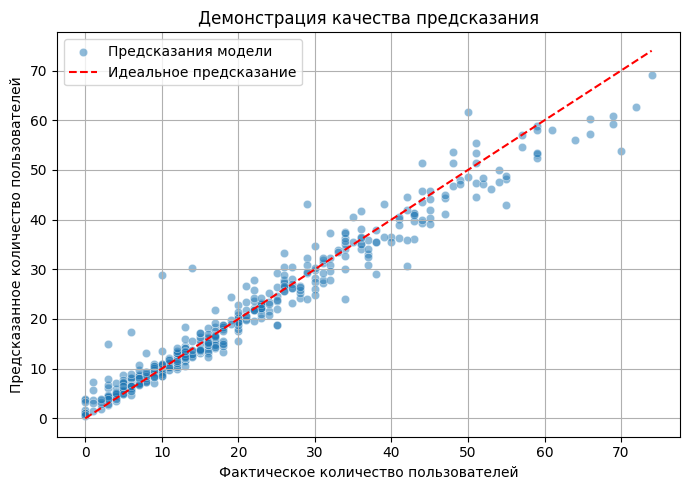

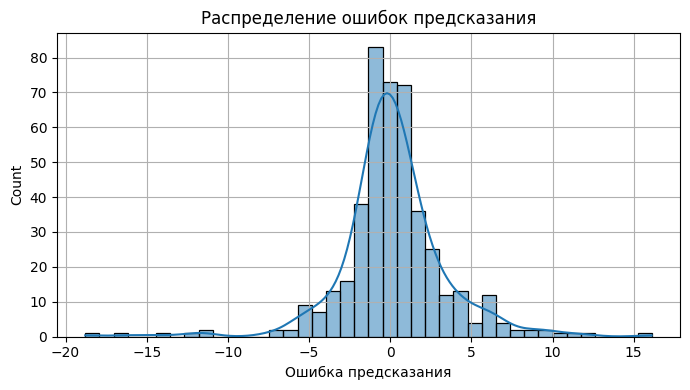

In [79]:
# Факт vs Предсказание (с легендой)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label='Предсказания модели')
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    label='Идеальное предсказание'
)
plt.xlabel("Фактическое количество пользователей")
plt.ylabel("Предсказанное количество пользователей")
plt.title("Демонстрация качества предсказания")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение ошибок предсказания")
plt.xlabel("Ошибка предсказания")
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# Важность признаков
importances = regressor.feature_importances_
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\n Важность признаков:")
print(feature_importance)

# Train MAE (для сравнения с тестом)
y_train_pred = regressor.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"\n📄 Лог обучения:")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test  MAE: {mae:.2f}")


 Важность признаков:
             feature  importance
8    rolling_mean_3h    0.789972
9     rolling_std_3h    0.054814
6  prev_2_hour_users    0.042892
5    prev_hour_users    0.034349
3       is_peak_hour    0.033125
0               hour    0.019976
4       is_event_day    0.008730
7  prev_3_hour_users    0.007091
1          dayofweek    0.005376
2         is_weekend    0.003677

📄 Лог обучения:
Train MAE: 0.87
Test  MAE: 2.15
